# Intro to SMuRF
The SMuRF software consists of a server and client.  The server and client are started in docker containers.  The SMuRF server provides and EPICS channel access interface to access PVs (registers, and higher level controls) and acquires the streaming data.  It can perform filtering/downsampling for CMB applications.



## Server startup

In a separate terminal we'll start the server with:
```bash
cd /home/cryo/docker/smurf/dev_sw/slotN/v4.1.0
./run.sh -N 2; docker logs -f smurf_server_s2
```
-N 2 specifies slot 2 and EPICS server prefix smurf_server_s2

A GUI will pop up that we can use to interrogate the FPGA registers


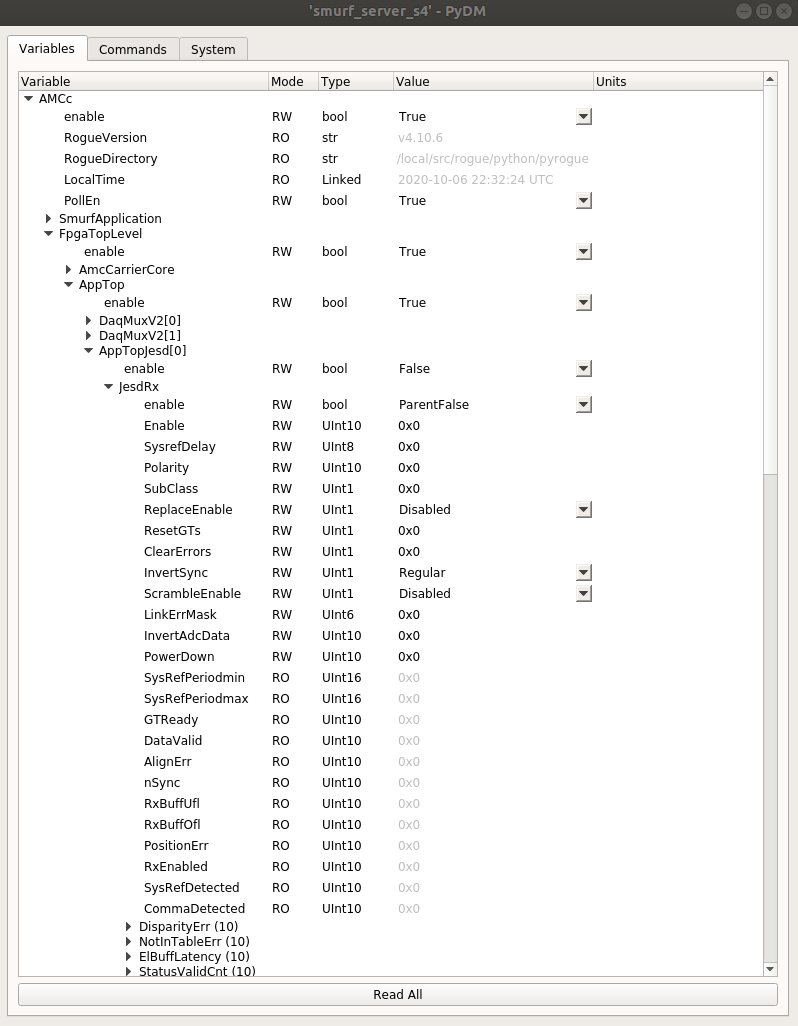

## PySMuRF Setup

PySMuRF is the client side control.  It communicates with the server via EPICS channel access (CA).  First we start the server and do imports

In [10]:
import pysmurf.client
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import epics
import os

%matplotlib inline

Next we'll define the EPICS server prefix and experiment configuration file

In [11]:
epics_prefix = "smurf_server_s5"
config_file  = "/usr/local/src/pysmurf/cfg_files/stanford/experiment_fp31_cc03-02_lbOnlyBay0.cfg"
S = pysmurf.client.SmurfControl(epics_root=epics_prefix, cfg_file=config_file, setup=False, make_logfile=False)

Next we run a setup command.  This will initialize the FPGA and load the configuration defined in config_file.

In [3]:
S.setup()

[ 2021-01-13 22:04:37 ]  Setting up...
[ 2021-01-13 22:04:37 ]  Toggling DACs
[ 2021-01-13 22:04:37 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[0] 1
[ 2021-01-13 22:04:37 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[1] 1
[ 2021-01-13 22:04:37 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[0] 0
[ 2021-01-13 22:04:37 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[1] 0
[ 2021-01-13 22:04:37 ]  caput smurf_server_s5:AMCc:ReadAll 1
[ 2021-01-13 22:04:42 ]  Waiting 20.00 seconds after...
[ 2021-01-13 22:05:02 ]  Done waiting.
[ 2021-01-13 22:05:02 ]  caget smurf_server_s5:AMCc:SmurfApplication:SmurfVersion
[ 2021-01-13 22:05:02 ]  4.1.0
[ 2021-01-13 22:05:02 ]  caput smurf_server_s5:AMCc:setDefaults 1
[ 2021-01-13 22:05:34 ]  caget smurf_server_s5:AMCc:SmurfApplication:ConfiguringInProgress
[ 2021-01-13 22:05:40 ]

[ 2021-01-13 22:05:42 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppTopJesd[0]:JesdTx:dataOutMux[7] UserData
[ 2021-01-13 22:05:42 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:dspEnable 1
[ 2021-01-13 22:05:42 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentGain 0.0001
[ 2021-01-13 22:05:42 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentAverages 1
[ 2021-01-13 22:05:42 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentConvergeHz 500.0
[ 2021-01-13 22:05:42 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentStepHz 1000.0
[ 2021-01-13 22:05:42 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentMomentum 1
[ 2021-01-13 22:05:42 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:A

[ 2021-01-13 22:05:45 ]  {'hemt_Vg': 0.27999861000000004, 'hemt_Id': 9.410114062499998, '50K_Vg': -0.7899972599999999, '50K_Id': 119.23828124999999}
[ 2021-01-13 22:05:45 ]  {'hemt_Vg': 0.27999861000000004, 'hemt_Id': 9.416559374999999, '50K_Vg': -0.7899972599999999, '50K_Id': 119.10937499999999}
[ 2021-01-13 22:05:45 ]  Cryocard temperature = 18.67117745535714
[ 2021-01-13 22:05:45 ]  Configuring the system to take timing from ext_ref
[ 2021-01-13 22:05:45 ]  Select external reference for bay 0
[ 2021-01-13 22:05:50 ]  smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:SelExtRef sent
[ 2021-01-13 22:05:50 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:RtmCryoDet:RampStartMode 0
[ 2021-01-13 22:05:50 ]  Done with setup.


True

Next we need to enable cryostat amplifiers bias (if using cryostat card)

In [4]:
# **** this is only used at Stanford for hacked cryostat card ****

exec(open('../shawn/cryocard_c03_setup.py').read())

-> Running cryocard_c03_setup.py ...
-> Enabling RTM DAC32, which drives DAC_In_50k_d
-> Setting DAC_In_50k_d to 0.65V for 50kVd=5.003
-> Enabling RTM DAC31, which drives DAC_In_H_d
-> Setting DAC_In_H_d to 6V for HVd=0.53
Done running cryocard_c03_setup.py.


In [6]:
S.set_amplifier_bias()
S.set_cryo_card_ps_en()
S.get_amplifier_bias()

[ 2021-01-13 22:10:14 ]  Setting HEMT LNA Vg from config file to Vg=0.280
[ 2021-01-13 22:10:14 ]  Setting 50K LNA Vg from config file to Vg=-0.790
[ 2021-01-13 22:10:15 ]  {'hemt_Vg': 0.27999861000000004, 'hemt_Id': 3.7833562499999993, '50K_Vg': -0.7899972599999999, '50K_Id': 62.90625}
[ 2021-01-13 22:10:15 ]  {'hemt_Vg': 0.27999861000000004, 'hemt_Id': 3.7833562499999993, '50K_Vg': -0.7899972599999999, '50K_Id': 62.90625}


{'hemt_Vg': 0.27999861000000004,
 'hemt_Id': 3.7833562499999993,
 '50K_Vg': -0.7899972599999999,
 '50K_Id': 62.90625}

### Inspecting the SMuRF digitizers

SMuRF uses x8 RF ADCs and x8 RF DACs.  They are upmixed and combined in via x2 quadruplexers to form 4GHz analog bandwidth from 4-8GHz.  SMuRF uses a 750MHz intermediate frequency withand the RF ADCs and DACs perform down/up conversion to/from complex baseband.  






The digitizers are upmixed and combined with a multiplexer:

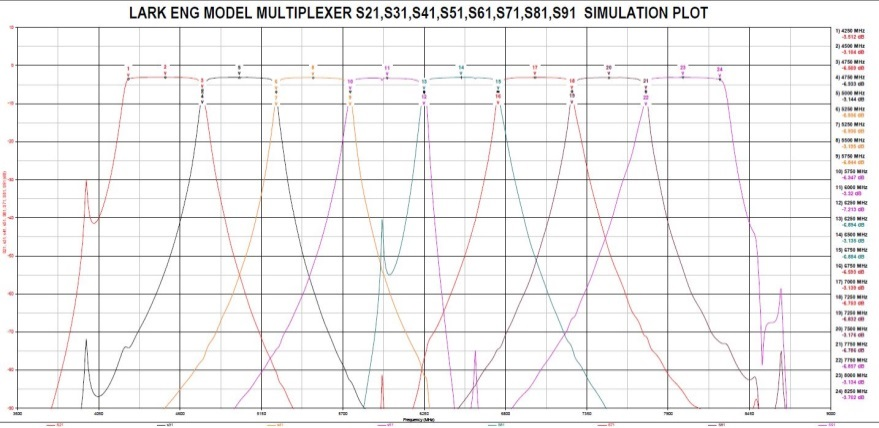

### Acquiring data from the digitzers

The SMuRF ADC and DACs are pictured below.  We can interrogate the raw ADC/DAC data with the following commands.  Here "band" defines which ADC/DAC to read data from.  Band 0...3 address AMC in the slot 0 and (when using low band AMC) correspond to 4-4.5GHz, 4.5-5GHz, 5-5.5GHz, and 5.5-6GHz.  Band 4...7 address the AMC in slot 1 and (when using the high band AMC) correspond to 6-6.5GHz, 6.5-7GHz, 7-7.5GHz and 7.5-8GHz.

The raw digitizer data is plotted in the top and a PSD is plotted below.  Raw data are 16-bit numbers +32767/-32768.  Let's look at the ADC data with no signals being played out of the DAC.



[ 2021-01-13 22:11:00 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2021-01-13 22:11:00 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 3
[ 2021-01-13 22:11:01 ]  ADC plot saved to /data/smurf_data/20210113/1610575474/plots/1610575860_adc3.png
[ 2021-01-13 22:11:01 ]  Saving raw adc data to /data/smurf_data/20210113/1610575474/outputs/1610575860_adc3


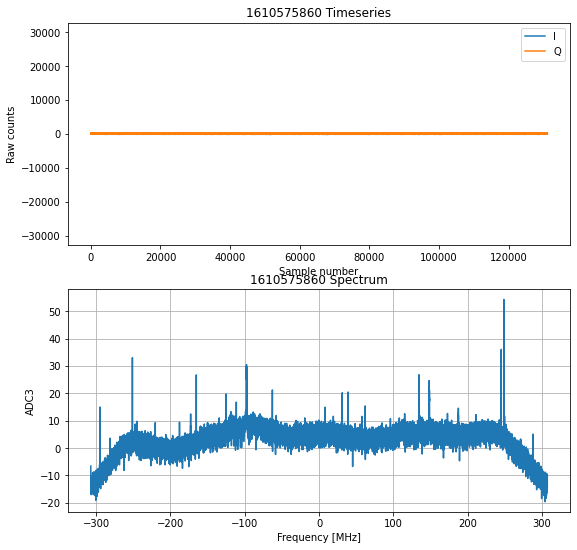

In [7]:
adc_data = S.read_adc_data(data_length=2**16, band=3, make_plot=True, show_plot=True)

[ 2021-01-13 22:11:03 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2021-01-13 22:11:03 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0


/usr/local/src/pysmurf/python/pysmurf/client/util/smurf_util.py:1724: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(f_plot, 10*np.log10(p_dac))


[ 2021-01-13 22:11:03 ]  DAC plot saved to /data/smurf_data/20210113/1610575474/plots/1610575863_dac0.png
[ 2021-01-13 22:11:03 ]  Saving raw dac data to /data/smurf_data/20210113/1610575474/outputs/1610575863_dac0


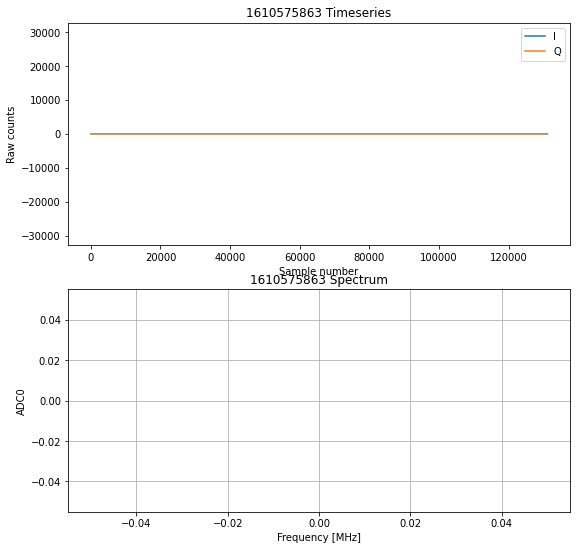

In [8]:
dac_data = S.read_dac_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

Note the PSD frequency is plotted +/- 0MHz. Each digitizer has complex data at 614.4MHz corresponding to +/- 307.2MHz BW at baseband.  For band=2 this is 0MHz + 5250MHz = 5250MHz.


### Transfer function of the system

Next we can look at a transfer function estimate.  This will play a known random number sequence through the DAC and record the ADC response.  We'll use cross correlation to generate a transfer function estimate:

[ 2021-01-13 22:25:13 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2021-01-13 22:25:13 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:25:14 ]  ADC2 max count: 2345
[ 2021-01-13 22:25:14 ]  ADC2 min count: -2376
[ 2021-01-13 22:25:14 ]  ADC2 not saturated
[ 2021-01-13 22:25:14 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:25:14 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:25:14 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:25:14 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:25:14 ]  UC (DAC) att: 24
[ 2021-01-13 22:25:14 ]  DC (ADC) att: 0
[ 2021-01-13 22:25:14 ]  UC attenuator > 0. Scaling by 0.251


/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


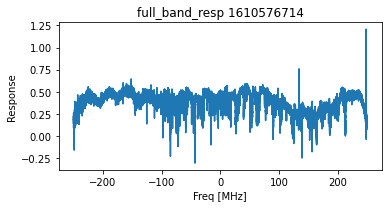

(array([-3.07200000e+08, -3.07197656e+08, -3.07195312e+08, ...,
         3.07192969e+08,  3.07195312e+08,  3.07197656e+08]),
 array([-0.00774382+0.00023698j,  0.00311779+0.00126901j,
         0.00265322+0.00970244j, ..., -0.00488427+0.00632306j,
         0.00343292+0.00370898j, -0.00321615+0.00478693j]))

In [12]:
S.full_band_resp(band=2, make_plot=True, show_plot=True)

Here we can see transmission through the cryostat with a number of resonators at +/- 250MHz from the band 2 center (5250MHz).

### Calibrating cable delay

There is a few microsecond delay through SMuRF -> cryostat -> signal processing.  Now that we have good transmission let's calibrate the delay.

[ 2021-01-13 22:25:20 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:ATT:UC[3] 24
[ 2021-01-13 22:25:20 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:ATT:DC[3] 0
[ 2021-01-13 22:25:21 ]  Running full band resp
[ 2021-01-13 22:25:21 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2021-01-13 22:25:21 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:25:21 ]  ADC2 max count: 2442
[ 2021-01-13 22:25:21 ]  ADC2 min count: -2402
[ 2021-01-13 22:25:21 ]  ADC2 not saturated
[ 2021-01-13 22:25:21 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:25:21 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:25:21 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:25:21 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


[ 2021-01-13 22:25:22 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2021-01-13 22:25:22 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:25:22 ]  ADC2 max count: 2600
[ 2021-01-13 22:25:22 ]  ADC2 min count: -2231
[ 2021-01-13 22:25:22 ]  ADC2 not saturated
[ 2021-01-13 22:25:22 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:25:22 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:25:22 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:25:22 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:25:23 ]  UC (DAC) att: 24
[ 2021-01-13 22:25:23 ]  DC (ADC) att: 0
[ 2021-01-13 22:25:23 ]  UC attenuator > 0. Scaling by 0.251
[ 2021-01-13 22:25:23 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2021-0

(21, 107, 7.674215149628299, 0.0659400986169296)

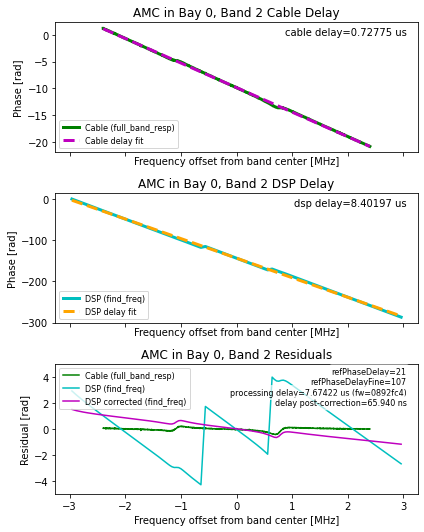

In [13]:
S.estimate_phase_delay(band=2)

### Identifying resonator locations

Each SMuRF band is processed by an oversampled x2 polyphase filter bank.  The filter bank breaks the +/-307.2MHz band into subbands.  Subband 0...511 correspond to -307.2MHz...307.2MHz.  Only subbands +/-250MHz are processed.  We can do a tone sweep to see the subband structure and identify resonator locations within each subband.  The plot shows the interleaved subbands in different colors.

[ 2021-01-13 22:26:12 ]  No tone_power given. Using value in config file: 12
[ 2021-01-13 22:26:12 ]  Sweeping across frequencies 5000.0MHz to 5500.0MHz
[ 2021-01-13 22:26:12 ]  Working on band 2
[ 2021-01-13 22:26:38 ]  serial find freq complete ; etaScanInProgress = 0


/usr/local/src/pysmurf/python/pysmurf/client/tune/smurf_tune.py:896: RuntimeWarning: invalid value encountered in double_scalars
  if 1-amp[idx]/med_amp[idx] > amp_cut:


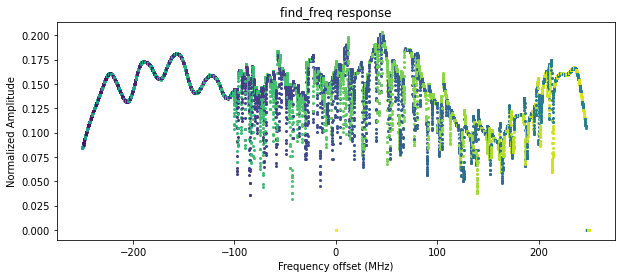

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [14]:
S.find_freq(band=2, start_freq=-250, stop_freq=250, make_plot=True, show_plot=True)

### Fine resolution resonator scans
Next we run a fine resonator scan and set the nominal tone frequency, drive power and rotation.  Feedback operates on the RF demodulated Q and performs feedback to drive Q to 0.  Serial gradient descent will walk down to the bottom of the resonator dip.  Finally the eta scan will apply rotation and scaling such that Q -> delta frequency from bottom of the dip.

In [15]:
S.setup_notches(band=2, new_master_assignment=True)
# Plots will be saved in S.plot_dir
S.plot_tune_summary(band=2, eta_scan=True)
print("These plots are saved at: " + S.plot_dir)
# run a gradient descent to find resonator dip
S.run_serial_gradient_descent(0) 
# run eta scan to normalize resonator gain (delta Q -> delta frequency) and apply rotation such that Q is nominally 0
S.run_serial_eta_scan(0) 

[ 2021-01-13 22:26:55 ]  No tone_power given. Using value in config file: 12
[ 2021-01-13 22:26:55 ]  freq 5149.3200 - 1 of 85
[ 2021-01-13 22:26:55 ]  freq 5152.2400 - 2 of 85
[ 2021-01-13 22:26:55 ]  freq 5153.4400 - 3 of 85
[ 2021-01-13 22:26:55 ]  freq 5156.5600 - 4 of 85
[ 2021-01-13 22:26:55 ]  freq 5157.5600 - 5 of 85
[ 2021-01-13 22:26:55 ]  freq 5160.6400 - 6 of 85
[ 2021-01-13 22:26:55 ]  freq 5164.2400 - 7 of 85
[ 2021-01-13 22:26:55 ]  freq 5165.2000 - 8 of 85
[ 2021-01-13 22:26:55 ]  freq 5166.3600 - 9 of 85
[ 2021-01-13 22:26:55 ]  freq 5167.2000 - 10 of 85
[ 2021-01-13 22:26:55 ]  freq 5168.8000 - 11 of 85
[ 2021-01-13 22:26:55 ]  freq 5172.3600 - 12 of 85
[ 2021-01-13 22:26:55 ]  freq 5175.5600 - 13 of 85
[ 2021-01-13 22:26:55 ]  freq 5178.4800 - 14 of 85
[ 2021-01-13 22:26:55 ]  freq 5180.0400 - 15 of 85
[ 2021-01-13 22:26:55 ]  freq 5181.2400 - 16 of 85
[ 2021-01-13 22:26:55 ]  freq 5187.8400 - 17 of 85
[ 2021-01-13 22:26:55 ]  freq 5190.6000 - 18 of 85
[ 2021-01-13 2

[ 2021-01-13 22:28:42 ]  Eta plot 67 of 85
[ 2021-01-13 22:28:43 ]  Eta plot 68 of 85
[ 2021-01-13 22:28:44 ]  Eta plot 69 of 85
[ 2021-01-13 22:28:45 ]  Eta plot 70 of 85
[ 2021-01-13 22:28:46 ]  Eta plot 71 of 85
[ 2021-01-13 22:28:46 ]  Eta plot 72 of 85
[ 2021-01-13 22:28:47 ]  Eta plot 73 of 85
[ 2021-01-13 22:28:48 ]  Eta plot 74 of 85
[ 2021-01-13 22:28:49 ]  Eta plot 75 of 85
[ 2021-01-13 22:28:50 ]  Eta plot 76 of 85
[ 2021-01-13 22:28:51 ]  Eta plot 77 of 85
[ 2021-01-13 22:28:51 ]  Eta plot 78 of 85
[ 2021-01-13 22:28:52 ]  Eta plot 79 of 85
[ 2021-01-13 22:28:53 ]  Eta plot 80 of 85
[ 2021-01-13 22:28:54 ]  Eta plot 81 of 85
[ 2021-01-13 22:28:55 ]  Eta plot 82 of 85
[ 2021-01-13 22:28:55 ]  Eta plot 83 of 85
[ 2021-01-13 22:28:56 ]  Eta plot 84 of 85
[ 2021-01-13 22:28:57 ]  Eta plot 85 of 85
These plots are saved at: /data/smurf_data/20210113/1610576697/plots


Here's our eta scan, the complex response is multiplied by the complex value eta to apply the scaling/rotation for feedback.

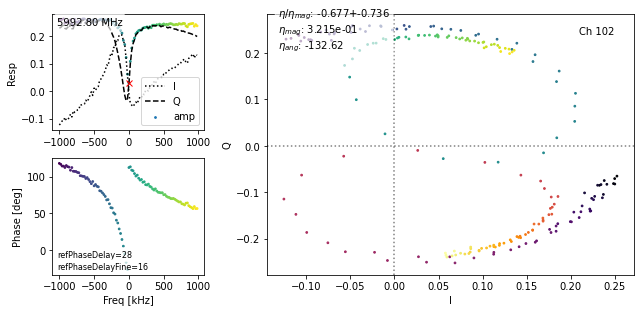

### Looking at on resonance noise
Now we can examine resonator noise.  The eta scan sets up with feedback enabled so we'll turn it off and look at open loop frequency error (quadrature voltage).

First we'll get of list of resonators that are on and tracking:

In [17]:
S.which_on(band=2)

array([  4,  15,  27,  32,  42,  48,  56,  63,  71,  72,  79,  88,  92,
        96, 103, 104, 107, 119, 123, 127, 135, 136, 154, 155, 168, 183,
       187, 192, 199, 204, 208, 212, 219, 223, 232, 244, 256, 264, 271,
       279, 284, 287, 290, 303, 304, 315, 328, 340, 351, 352, 360, 367,
       370, 383, 384, 388, 411, 415, 416, 420, 432, 434, 443, 448, 455,
       458, 460, 463, 464, 468, 471, 472, 480, 487, 490, 491, 492, 507,
       508, 511])

[ 2021-01-13 22:37:54 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:readoutChannelSelect 15
[ 2021-01-13 22:37:54 ]  Writing to file : /data/smurf_data/20210113/1610576697/outputs/1610577475.dat
[ 2021-01-13 22:37:54 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:37:54 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:37:54 ]  Data acquisition in progress...
[ 2021-01-13 22:37:54 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-01-13 22:37:57 ]  Done taking data


Text(0, 0.5, 'Frequency error (MHz)')

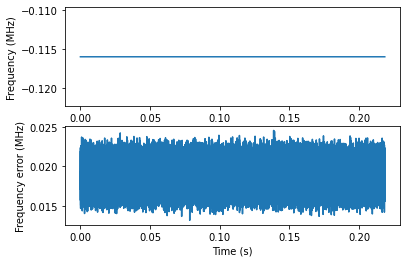

In [28]:
S.set_feedback_enable(band=2, val=0)
fs = 2.4e6
f, df, sync = S.take_debug_data(band=2, channel=15, nsamp=2**19, IQstream=0, single_channel_readout=2)
t = np.arange(len(df))/fs
plt.subplot(211)
plt.plot(t, f)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.subplot(212)
plt.plot(t, df)
plt.xlabel('Time (s)')
plt.ylabel('Frequency error (MHz)')

Text(0.5, 1.0, 'Frequency error PSD')

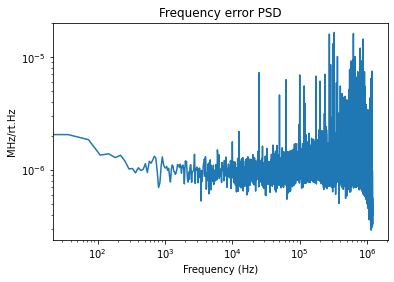

In [29]:
freq, pxx = signal.welch(df, nperseg=len(df)/8, fs=fs)
plt.loglog(freq, np.sqrt(pxx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('MHz/rt.Hz')
plt.title('Frequency error PSD')

Now let's enable feedback and look at frequency and frequency error

[ 2021-01-13 22:51:34 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:readoutChannelSelect 15
[ 2021-01-13 22:51:34 ]  Writing to file : /data/smurf_data/20210113/1610576697/outputs/1610578294.dat
[ 2021-01-13 22:51:34 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:51:34 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:51:34 ]  Data acquisition in progress...
[ 2021-01-13 22:51:34 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-01-13 22:51:36 ]  Done taking data


Text(0, 0.5, 'Frequency error (MHz)')

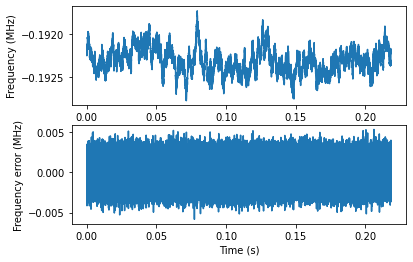

In [41]:
S.set_feedback_enable(band=2, val=1)
fs = 2.4e6
f, df, sync = S.take_debug_data(band=2, channel=15, nsamp=2**19, IQstream=0, single_channel_readout=2)
t = np.arange(len(df))/fs
plt.subplot(211)
plt.plot(t, f)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.subplot(212)
plt.plot(t, df)
plt.xlabel('Time (s)')
plt.ylabel('Frequency error (MHz)')

Text(0.5, 1.0, 'Tracked frequency PSD')

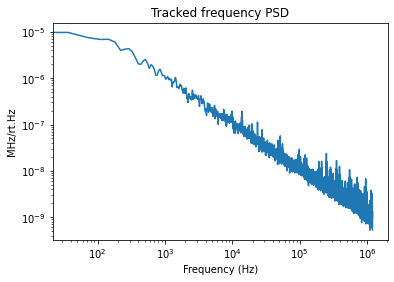

In [42]:
freq, pxx = signal.welch(f, nperseg=len(df)/8, fs=fs)
plt.loglog(freq, np.sqrt(pxx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('MHz/rt.Hz')
plt.title('Tracked frequency PSD')

Text(0.5, 1.0, 'Frequency error PSD')

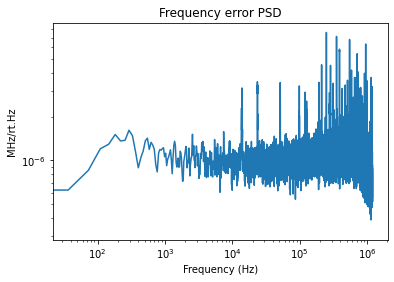

In [43]:
freq, pxx = signal.welch(df, nperseg=len(df)/8, fs=fs)
plt.loglog(freq, np.sqrt(pxx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('MHz/rt.Hz')
plt.title('Frequency error PSD')

We can change feedback gain and look at tracked frequency response

[ 2021-01-13 22:52:58 ]  Before toggling feedback on band 2, feedbackEnable=1, lmsEnable1=1, lmsEnable2=0, and lmsEnable3=0.
[ 2021-01-13 22:52:58 ]  Setting feedbackEnable=lmsEnable1=lmsEnable2=lmsEnable3=0 (in that order).
[ 2021-01-13 22:52:58 ]  Set feedbackEnable=lmsEnable1=1 (in that order).
[ 2021-01-13 22:52:58 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:readoutChannelSelect 15
[ 2021-01-13 22:52:58 ]  Writing to file : /data/smurf_data/20210113/1610576697/outputs/1610578379.dat
[ 2021-01-13 22:52:58 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:52:58 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:52:58 ]  Data acquisition in progress...
[ 2021-01-13 22:52:58 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-01-13 22:53:01 ]  Done taking data
[ 2021-01-13 22:53:01 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppC

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


[ 2021-01-13 22:53:06 ]  Done taking data
[ 2021-01-13 22:53:06 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:readoutChannelSelect 15
[ 2021-01-13 22:53:06 ]  Writing to file : /data/smurf_data/20210113/1610576697/outputs/1610578386.dat
[ 2021-01-13 22:53:06 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:53:06 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:53:06 ]  Data acquisition in progress...
[ 2021-01-13 22:53:06 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


[ 2021-01-13 22:53:08 ]  Done taking data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


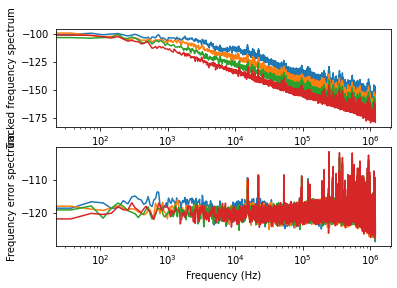

In [45]:
S.flux_ramp_off()
S.toggle_feedback(band=2)
gain = [8192, 4096, 2048, 1024]

for g in gain:
    S.set_feedback_gain(band=2, val=g)
    f, df, sync = S.take_debug_data(band=2, channel=15, nsamp=2**19, IQstream=0, single_channel_readout=2)
    
    plt.subplot(211)
    freq, pxx = signal.welch(f, nperseg=len(f)/8, fs=fs)
    plt.semilogx(freq, 10*np.log10(pxx))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Tracked frequency spectrum')
    
    plt.subplot(212)
    freq, pxx = signal.welch(df, nperseg=len(f)/8, fs=fs)
    plt.semilogx(freq, 10*np.log10(pxx))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Frequency error spectrum')
    
S.set_feedback_gain(band=2, val=4096)
    

### Flux ramp setup
Next we enable and configure the flux ramp.  For this example we'll setup 4phi0 flux ramp amplitude at 4kHz flux ramp rate (16kHz phi0 rate).

First we'll get a list of resonators that are on and tracking:

In [46]:
S.which_on(band=2)

array([  4,  15,  27,  32,  42,  48,  56,  63,  71,  72,  79,  88,  92,
        96, 103, 104, 107, 119, 123, 127, 135, 136, 154, 155, 168, 183,
       187, 192, 199, 204, 208, 212, 219, 223, 232, 244, 256, 264, 271,
       279, 284, 287, 290, 303, 304, 315, 328, 340, 351, 352, 360, 367,
       370, 383, 384, 388, 411, 415, 416, 420, 432, 434, 443, 448, 455,
       458, 460, 463, 464, 468, 471, 472, 480, 487, 490, 491, 492, 507,
       508, 511])

Next we'll do tracking setup and view results for one of the enabled channels.  We'll set:  

reset_rate = 4 (kHz)  
n_phi0     = 4 (requested)  

meas_flux_ramp_amp = True (measure and adjust flux ramp amplitude to achieve requested phi0)
lms_freq_hz = None (we'll use requested reset rate, n_phi0, and meas_flux_ramp_amp for this)

Track the middle 3 phi0:  

start_feedback = 0.125  
end_feedback   = 0.875  

lms_enable1 = 1 (track fundamental phi0 response)  
lms_enable2 = 0 (don't track 2nd harmoncis of phi0 response)  
lms_enable3 = 0 (don't track 3rd harmonic of phi0 response)  

[ 2021-01-13 22:53:35 ]  Starting fraction full scale : 0.641
[ 2021-01-13 22:53:36 ]  Percent full scale = 64.095%
[ 2021-01-13 22:53:36 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:singleChannelReadout 0
[ 2021-01-13 22:53:36 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:singleChannelReadoutOpt2 0
[ 2021-01-13 22:53:36 ]  Writing to file : /data/smurf_data/20210113/1610576697/outputs/1610578416.dat
[ 2021-01-13 22:53:36 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-01-13 22:53:36 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2021-01-13 22:53:36 ]  Data acquisition in progress...
[ 2021-01-13 22:53:36 ]  caput smurf_server_s5:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-01-13 22:53:37 ]  Done taking data
[ 2021-01-13 22:53:38 ]  Number of channels on : 80
[ 2021-01-13 22:53:38 ]  Number of channels on with flux ramp response : 78
[ 2021

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.54766846e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.60488892e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.66210937e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 6.75201416e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 6.80923462e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 6.86645508e-05]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.56197357e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.61919403e-05],
        [0.00000000e+00, 

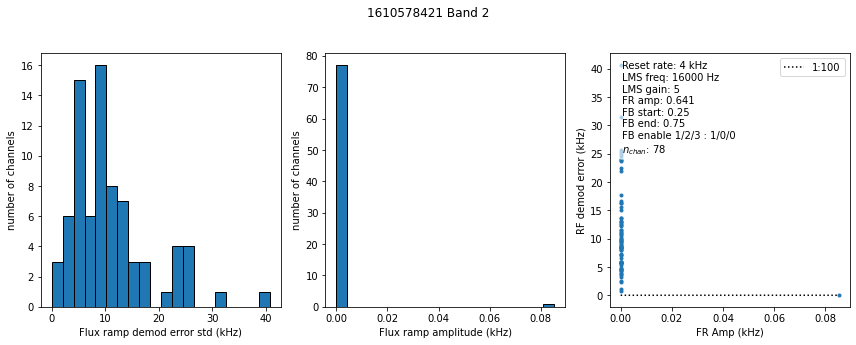

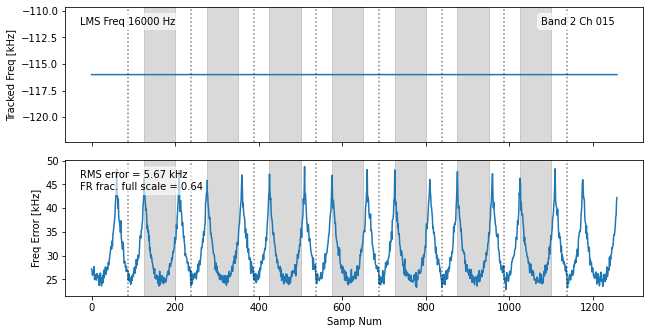

In [47]:
S.set_feedback_enable(2, 0)
S.tracking_setup(band=2, channel=15, reset_rate_khz=4, n_phi0=4, lms_freq_hz=None, meas_flux_ramp_amp=True, make_plot=True, lms_gain=5, feedback_start_frac=0.25, feedback_end_frac=1-0.25, lms_enable1=1, lms_enable2=0, lms_enable3=0) 

The plots are an overall tuning summary (tracked frequency throw, RMS tracking error) and a channel plot for the requested channel.  Here we see tracked frequency is aroudn -80kHz to -40kHz for 4 phi0.  The dottled lines indicate flux ramp reset and the grey area shows what part of the response we are tracking.  The bottom plot shows frequency errror.  Here we are only tracking the 16kHz and the error shows this.

Next let's try tracking 3 harmonics of the phi0 rate.

[ 2020-10-06 23:26:11 ]  Starting fraction full scale : 0.885
[ 2020-10-06 23:26:11 ]  Percent full scale = 88.480%
[ 2020-10-06 23:26:12 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadout 0
[ 2020-10-06 23:26:12 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadoutOpt2 0
[ 2020-10-06 23:26:12 ]  Writing to file : /data/smurf_data/20201006/1602026584/outputs/1602026772.dat
[ 2020-10-06 23:26:12 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2020-10-06 23:26:12 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-06 23:26:12 ]  Data acquisition in progress...
[ 2020-10-06 23:26:12 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2020-10-06 23:26:13 ]  Done taking data
[ 2020-10-06 23:26:13 ]  Number of channels on : 4
[ 2020-10-06 23:26:13 ]  Number of channels on with flux ramp response : 1
[ 2020-1

(array([[-0.08080845,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.00021229],
        [-0.08114834,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.00021458],
        [-0.08146649,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.00021687],
        ...,
        [-0.03389053,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.00075474],
        [-0.03367653,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.00075703],
        [-0.03354492,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.00075932]]),
 array([[-0.00031471,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.00021172],
        [-0.00115242,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.000214  ],
        [-0.00094757,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.00021629],
        ...,
        [-0.00151005,  0.        ,  0.        , ...,  

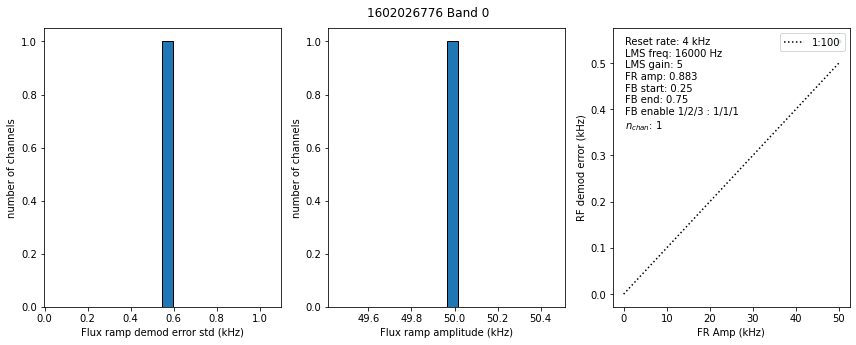

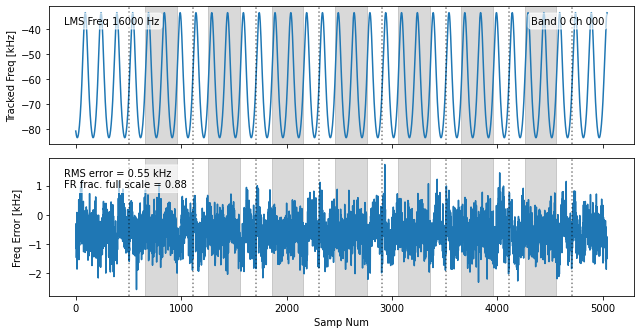

In [11]:
S.tracking_setup(band=0, channel=0, reset_rate_khz=4, n_phi0=4, lms_freq_hz=None, meas_flux_ramp_amp=True, make_plot=True, lms_gain=5, feedback_start_frac=0.25, feedback_end_frac=1-0.25, lms_enable1=1, lms_enable2=1, lms_enable3=1) 

Our error signal is cleaned up and we are now tracking 3 harmonics of the phi0 response.

### Examine DAC output
We can again look at the DAC output but this time we will be playing tones and doing flux ramp tracking:


[ 2020-10-06 23:26:21 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2020-10-06 23:26:21 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-06 23:26:21 ]  DAC plot saved to /data/smurf_data/20201006/1602026584/plots/1602026781_dac0.png
[ 2020-10-06 23:26:21 ]  Saving raw dac data to /data/smurf_data/20201006/1602026584/outputs/1602026781_dac0


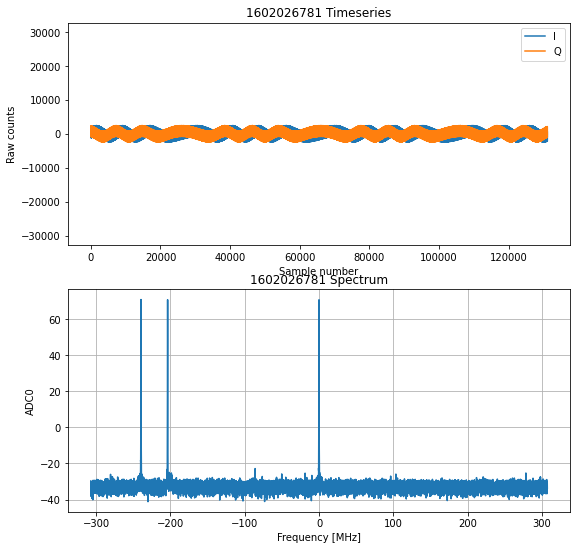

In [12]:
dac_data = S.read_dac_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

[ 2020-10-06 23:26:22 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2020-10-06 23:26:22 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-06 23:26:23 ]  ADC plot saved to /data/smurf_data/20201006/1602026584/plots/1602026783_adc0.png
[ 2020-10-06 23:26:23 ]  Saving raw adc data to /data/smurf_data/20201006/1602026584/outputs/1602026783_adc0


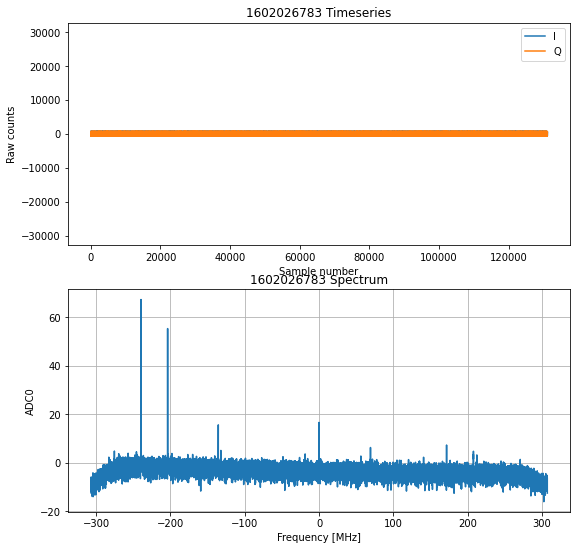

In [13]:
adc_data = S.read_adc_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

Our resonator at 0MHz had the largest depth and we can see the power at the ADC is lowest.

### Turn everything off

In [49]:
S.all_off()        # turn everything off (expect amplifiers)
S.C.write_ps_en(0) # turns off amplifiers

[ 2021-01-13 22:59:13 ]  Turning off tones
[ 2021-01-13 22:59:21 ]  Turning off flux ramp
[ 2021-01-13 22:59:21 ]  Turning off all TES biases
